In [46]:
from __future__ import print_function
import mxnet as mx
from mxnet import nd, autograd, gluon
import matplotlib.pyplot as plt
mx.random.seed(1)
ctx = mx.cpu()


In [47]:
n_inputs = 2
n_ouputs = 1
n_examples = 10000

def real_f(X):
    return 2*X[:, 0] - 3.4*X[:, 1] + 4.2

X = nd.random_normal(shape = (n_examples, n_inputs), ctx = ctx)
noise = .1*nd.random_normal(shape=(n_examples), ctx = ctx)
y = real_f(X) + noise

print(X[0])
print(len(X))
print(y[0])
print(len(y))


[ 0.03629481 -0.4902442 ]
<NDArray 2 @cpu(0)>
10000

[6.0096445]
<NDArray 1 @cpu(0)>
10000


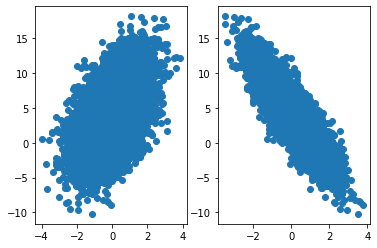

In [48]:
plt.subplot(1,2,1)
plt.scatter(X[:,0].asnumpy(), y.asnumpy())
plt.subplot(1,2,2)
plt.scatter(X[:,1].asnumpy(), y.asnumpy())

plt.show()

In [49]:
batch_size = 4
dataloader = gluon.data.DataLoader(gluon.data.ArrayDataset(X,y), batch_size =batch_size, shuffle=True)

In [50]:
w = nd.random_normal(shape = (n_inputs, n_ouputs), ctx=ctx)
b = nd.random_normal(shape = n_ouputs, ctx = ctx)

params = [w,b]

for param in params:
    param.attach_grad()
    
    
print(w)
print(b)

print(w.grad)


[[-0.48563418]
 [ 1.6041543 ]]
<NDArray 2x1 @cpu(0)>

[0.33379942]
<NDArray 1 @cpu(0)>

[[0.]
 [0.]]
<NDArray 2x1 @cpu(0)>


In [51]:
def net(X):
    return mx.nd.dot(X, w) + b

def square_loss(yhat, y):
    return nd.mean((yhat - y)**2)

def SGD(params, lr):
    for param in params:
        param[:] = param - lr*param.grad

In [52]:
epochs = 10
learning_rate = .0001
num_batches = n_examples/batch_size

for e in range(epochs):
    cumulative_loss = 0
    # inner loop
    for i, (data, label) in enumerate(dataloader):
        data = data.as_in_context(ctx)
        label = label.as_in_context(ctx).reshape((-1, 1))
        with autograd.record():
            output = net(data)
            loss = square_loss(output, label)
        loss.backward()
        SGD(params, learning_rate)
        cumulative_loss += loss.asscalar()
    print(cumulative_loss / num_batches)

29.295479586198926
10.715206346446276
3.923786978068948
1.4410644744843244
0.5334226604085649
0.20156147877275943
0.08017767288011965
0.03578288818632718
0.019534507821244187
0.013603084606921766


In [69]:
#Build a model with Gluon
net = gluon.nn.Dense(1)
print(net.collect_params())

net.collect_params().initialize(mx.init.Normal(sigma=1.0), ctx = ctx)

square_loss = gluon.loss.L2Loss()

trainer = gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate':0.0001})

epochs = 20
loss_sequence = []
n_batches = n_examples / batch_size

for e in range(epochs):
    cum_loss = 0
    for i, (data, label) in enumerate(dataloader):
        with autograd.record():
            ypred = net(data)
            loss = square_loss(ypred, label)
        loss.backward()
        trainer.step(batch_size)
        cum_loss += nd.mean(loss).asscalar()
    print(cum_loss)
    loss_sequence.append(cum_loss)

dense7_ (
  Parameter dense7_weight (shape=(1, 0), dtype=float32)
  Parameter dense7_bias (shape=(1,), dtype=float32)
)
28675.922159343958
17306.22790169716
10446.395947381854
6307.767276030034
3810.790931556374
2304.281019547954
1395.3145605865866
846.8877289281227
516.0063310540281
316.3628771356307
195.91900178184733
123.2551201354363
79.40819323487813
52.95772156950261
36.99115336773684
27.359403150359867
21.550617931578017
18.050936243322212
15.937535989258322
14.661471352206718


In [70]:
print(net.weight.data())
print(net.bias.data())


[[ 1.9892628 -3.3784387]]
<NDArray 1x2 @cpu(0)>

[4.1746254]
<NDArray 1 @cpu(0)>
